In [14]:
import os
from PIL import Image, ImageFont
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.ndimage import filters

import clip
from clip.simple_tokenizer import SimpleTokenizer
from utils.initialize_font_data import (
    font_dir,
    fox_text_four_lines,
    train_json_path,
    exclusive_attributes,
    gray_scale_image_file_dir,
)
from utils.init_model import (
    model,
    preprocess,
    my_preprocess,
    device,
    convert_weights,
    model_name,
    _download,
    _MODELS,
    load,
)
from utils.transform_image import draw_text_with_new_lines
from dataset.dataset import MyDataset, set_image_tensors
from utils.coop_model import CoOpCLIP

tokenizer = SimpleTokenizer()

In [6]:
def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x


# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02 * max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap("jet")
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = (
        1 * (1 - attn_map**0.7).reshape(attn_map.shape + (1,)) * img
        + (attn_map**0.7).reshape(attn_map.shape + (1,)) * attn_map_c
    )
    return attn_map


def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.0

def convert_image_to_numpy(image: Image.Image):
    image = image.convert("RGB")
    return np.asarray(image).astype(np.float32) / 255.0

In [44]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module, input: torch.Tensor, target: torch.Tensor, layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        print(output.shape)
        print(grad.shape)
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # alpha = grad.mean()
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam, input.shape[2:], mode="bicubic", align_corners=False
    )

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

(200, 200, 3)


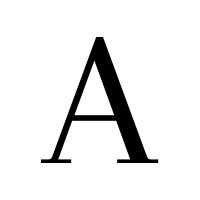

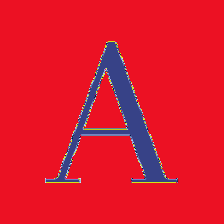

In [45]:
text = "A"
character_size = 200

line_count = text.count("\n") + 1
img_width = len(max(text.split("\n"), key=len)) * character_size
img_height = character_size * (line_count)
font_path = '../gwfonts/Arapey-Regular.ttf'
font = ImageFont.truetype(font_path, character_size)
image = draw_text_with_new_lines(text, font, img_width=character_size, img_height=character_size)
preprocessed_image = preprocess(image)
preprocessed_image_np = convert_image_to_numpy(image)
print(preprocessed_image_np.shape)
display(image)
display(to_pil_image(preprocessed_image))

In [46]:
prompt = "serif font"
image_input = preprocessed_image.unsqueeze(0).to(torch.float16).to(device)
text_input = clip.tokenize(prompt).to(device)
print(image_input.shape, text_input.shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 77])


In [47]:
saliency_layer = "transformer"
attn_map = gradCAM(
    model.visual,
    image_input,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer),
)

torch.Size([1, 512])
torch.Size([50, 1, 768])


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)